In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import dataframe_image as dfi

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

## Explore Database

In [7]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [8]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

### Precipitation Analysis

In [16]:
# Calculate the latest date in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date


('2017-08-23')

In [17]:
# Calculate the date 1 year ago from the last data point in the database
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago_date

datetime.date(2016, 8, 23)

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_last_12months = session.query(Measurement.date, Measurement.prcp,Measurement.station,Measurement.tobs).\
    filter(Measurement.date.between(year_ago_date, '2017-8-23')).all()
prcp_last_12months

# Select only the `date` and `prcp` values
prcp_date = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(year_ago_date, '2017-8-23')).all()
prcp_date

# Load the query results into a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(prcp_date).set_index("date").sort_values(by = 'date')
precipitation_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


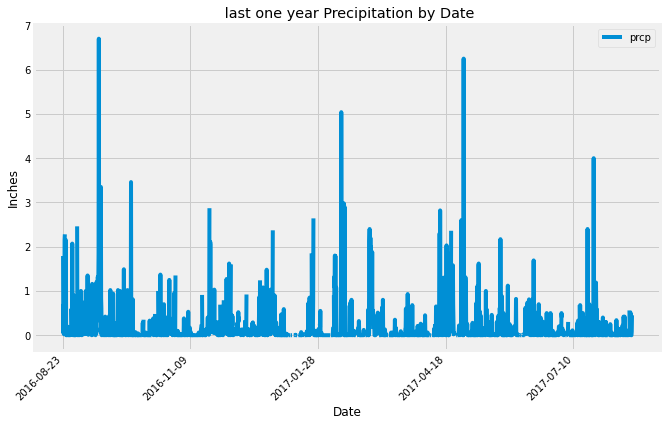

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title(" last one year Precipitation by Date")
plt.xticks(rotation = "45", horizontalalignment = "right")
plt.savefig("./Images/Precipitation.png")
plt.show()


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data'
prcp_describe = precipitation_df.describe()
dfi.export(prcp_describe, './Images/describe.png')
prcp_describe

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [21]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).distinct().count()
station_count

9

In [26]:
# List the stations and the counts in descending order to find the most active station
station_desc_order = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_desc_order 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
print(f"The most active station is : {station_desc_order[0][0]}")

The most active station is : USC00519281


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_tobs = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
highest_tobs = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
avg_tobs = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
print(f'Lowest temperature recorded : {lowest_tobs}')
print('------------')
print(f'Highest temperature recorded : {highest_tobs}')
print('------------')
print(f'Average temperature recorded : {avg_tobs}')

Lowest temperature recorded : 54.0
------------
Highest temperature recorded : 85.0
------------
Average temperature recorded : 71.66378066378067


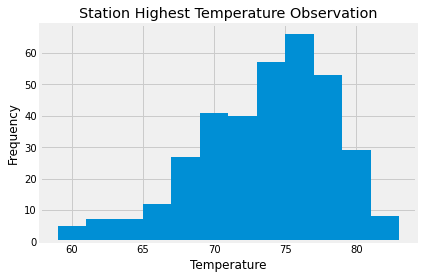

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_highest_temp = session.query(Measurement.date,Measurement.tobs).\
                       filter(Measurement.station == "USC00519281").\
                       filter(Measurement.date.between(year_ago_date, '2017-8-23')).all()
station_highest_temp

tobs_df = pd.DataFrame(station_highest_temp).set_index("date").sort_values(by='date')
plt.hist(tobs_df["tobs"], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Station Highest Temperature Observation')
plt.savefig("./Images/Station_Histogram.png")
plt.show()

## Bonus Challenge Assignment

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# function usage
print(calc_temps('2017-03-21', '2017-03-31'))

[(68.0, 74.38805970149254, 80.0)]


Text(-2.969999999999999, 0.5, 'Temp (F)')

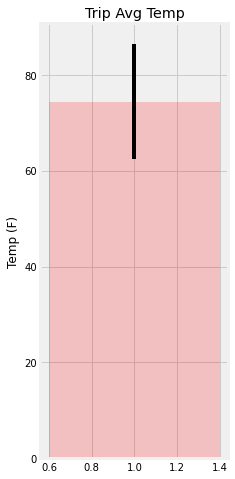

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

max_temp = 80.0
min_temp = 68.0
avg_temp = 74.38805970149254
temp_diff = max_temp - min_temp

plt.figure(figsize=(3, 8))
plt.bar(1,avg_temp, yerr = temp_diff, color = "red", alpha = 0.2)
plt.title("Trip Avg Temp")
plt.savefig('./Images/Temperature.png')
plt.ylabel('Temp (F)')

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [37]:
# Plot the daily normals as an area plot with `stacked=False`
